# TESTING MASK EFFECTS

- Create N(z)
- Cosmosis run
- Read Cl's from Cosmosis
- Run Synfast
- run reconstruction + masking afterwards
- run reconstruction + masking beforehand
- compute F1, F2 statistics

# Create Nz

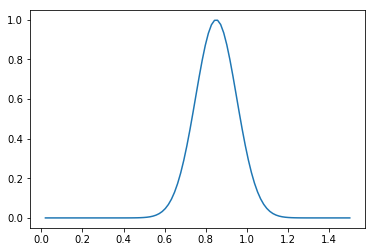

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import subprocess
import healpy as hp
from astropy.table import Table
import os
from scipy.interpolate import interp1d
import pyfits as pf

z_mean = 0.85
sigma_z = 0.02
z = np.linspace(0.02,1.5,100)
Nz = np.exp(-((z_mean-z)**2/sigma_z))
plt.plot(z,Nz)

# Run Cosmosis

In [20]:
def run_cosmosis_command(command, path_to_cosmosis='.'):
    cmd = ['bash', '-c', 'source /Users/mgatti/Desktop/Marco/utilities/cosmosis/setup-my-cosmosis && {1}'.format(path_to_cosmosis, command)]
    process = subprocess.Popen(cmd)
    process.wait()
    return process

nz_vec=np.vstack((z,Nz)).T
np.savetxt('n_of_z.txt',nz_vec)

run_cosmosis_command("cosmosis.txt demo6.ini")

# Run synfast 

In [6]:
# read Cls ***********************
elle = np.loadtxt('./out/shear_cl/ell.txt')
cl = np.loadtxt('./out/shear_cl/bin_1_1.txt')
cl_int = interp1d(elle,cl)

nside = 1024
elle_new= range(2,nside+1)

lmax = nside *2
cls = np.hstack([cl[0],cl_int(elle_new)])
cls2 =  [cls,cls,np.zeros(len(cls)),np.zeros(len(cls))] #[TT, EE, BB, TE]

# Run synfast **************************
K,gamma1,gamma2 = hp.synfast(cls2, nside, lmax=lmax, pol = True) #TQU=K,y1,y2
# cl_crosscheck=hp.sphtfunc.anafast(K,lmax = lmax) 

Maps = [K, gamma1, gamma2]
names = ['k', 'e1', 'e2']

# save maps ****************************
path = 'test_synfast_lmax{0}_{1}.fits'.format(lmax,z_mean)
fits_f = Table()
if not os.path.exists(path):
    for i in range(len(names)):
        fits_f[names[i]] = Maps[i]
    fits_f.write(path)


/Users/mgatti/anaconda/envs/py27/lib/python2.7/site-packages/healpy/sphtfunc.py:295: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


# Check methodology

In [7]:
def g2k_sphere(kappa, gamma1, gamma2, mask, nside=1024, lmax=2048, synfast=False, sm=False):
    """
    Convert shear to convergence on a sphere. In put are all healpix maps.
    """

    kappa_mask = kappa * mask
    gamma1_mask = gamma1 * mask
    gamma2_mask = gamma2 * mask

    KQU_masked_maps = [kappa_mask, gamma1_mask, gamma2_mask]
    alms = hp.map2alm(KQU_masked_maps, lmax=lmax, pol=True)  # Spin transform!

    if synfast == False:  # 1/2 missing? **
        ell, emm = hp.Alm.getlm(lmax=lmax)
        almsE = alms[1] * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
        almsB = alms[2] * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
        almsE[ell == 0] = 0.0
        almsB[ell == 0] = 0.0
        almsE[ell == 1] = 0.0
        almsB[ell == 1] = 0.0

    else:
        almsE = alms[1]
        almsB = alms[2]
        print (almsB)

    almssm = [alms[0], almsE, almsB]

    if sm == False:
        kappa_map_alm = hp.alm2map(almssm[0], nside=nside, lmax=lmax, pol=False)
        E_map = hp.alm2map(almssm[1], nside=nside, lmax=lmax, pol=False)
        B_map = hp.alm2map(almssm[2], nside=nside, lmax=lmax, pol=False)

    else:
        kappa_map_alm = hp.alm2map(almssm[0], nside=nside, lmax=lmax, pol=False, sigma=sm)
        E_map = hp.alm2map(almssm[1], nside=nside, lmax=lmax, pol=False, sigma=sm)
        B_map = hp.alm2map(almssm[2], nside=nside, lmax=lmax, pol=False, sigma=sm)

    return kappa_mask, kappa_map_alm, E_map, B_map

In [9]:
# input **********************************
mask_path = '../output_files/test_map_bigger_MASK_0.6_1.2.fits'

# generates maps *************************
kappa_mask, kappa_map_alm, E_map, B_map = g2k_sphere(K, gamma1, gamma2, np.ones(len(gamma1)), nside, lmax, synfast=True, sm=False)

# smooth *********************************
sigma_smooth = 30.
sigma_smooth1 = (sigma_smooth/60.)*np.pi/180.

kappa_mask_smoothed = hp.sphtfunc.smoothing(kappa_mask, sigma = sigma_smooth1)
E_map_smoothed = hp.sphtfunc.smoothing(E_map, sigma = sigma_smooth1)
B_map_smoothed = hp.sphtfunc.smoothing(B_map, sigma = sigma_smooth1)

# load mask ******************************
mute = pf.open(mask_path)
mask = mute[1].data['MASK']
mask = mask == 0.

# Apply mask ******************************
kappa_mask_sm_msk = np.ma.masked_where(mask, kappa_mask_smoothed)
E_map_sm_msk = np.ma.masked_where(mask, E_map_smoothed)
B_map_sm_msk = np.ma.masked_where(mask, B_map_smoothed)

[  0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j
  -1.38810026e-19 +0.00000000e+00j ...,  -1.41997779e-21 -6.17026497e-22j
  -8.54748344e-22 +3.20154879e-22j  -5.01171603e-22 +6.45871246e-22j]
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 30.000000 arcmin (0.008727 rad) 
-> fwhm is 70.644601 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 30.000000 arcmin (0.008727 rad) 
-> fwhm is 70.644601 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 30.000000 arcmin (0.008727 rad) 
-> fwhm is 70.644601 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


# Plotting results

In [15]:
from matplotlib.projections.geo import GeoAxes
import pyfits as pf 
from copy import copy

def plot_map(mapa, lonra, latra, res, vmin = None, vmax = None, title = None, x_len = 10, y_len = 3):
    class ThetaFormatterShiftPi(GeoAxes.ThetaFormatter):
        """Shifts labelling by pi
        Shifts labelling from -180,180 to 0-360"""
        def __call__(self, x, pos=None):
            if x != 0:
                x *= -1
            if x < 0:
                x += 2*np.pi
            return GeoAxes.ThetaFormatter.__call__(self, x, pos)

    mute2=mapa

#test = hp.cartview(mute2, lonra=[-38, -10], latra=[-2.5, 2.5], cbar = True, notext= False)

    nside = hp.pixelfunc.npix2nside(len(mapa))
    
    XSIZE = np.int((max(lonra)-min(lonra))/(res/60.))
    YSIZE = np.int((max(latra)-min(latra))/(res/60.))
   
    ra = np.linspace(lonra[0], lonra[1], XSIZE)
    dec   = np.linspace(latra[0], latra[1], YSIZE)



# project the map to a rectangular matrix xsize x ysize
    ra , dec = np.meshgrid(ra, dec)
    grid_pix = hp.pixelfunc.ang2pix(nside, np.radians(-dec+90.), np.radians(ra),nest=False)



    fig = plt.figure(figsize=(x_len,y_len))

#ax = fig.add_subplot(111,projection='mollweide')
    ax = fig.add_subplot(111)
    
    palette = copy(plt.cm.bwr)
    #palette.set_over('r', 1.0)
    #palette.set_under('g', 1.0)
    palette.set_bad('grey', 1.0)
    #cmap1.set_bad('grey') 

    image = plt.pcolormesh(ra, dec, mute2[grid_pix], rasterized=True, cmap = palette , vmin = vmin, vmax = vmax)




    # colorbar
    cb = fig.colorbar(image, orientation='vertical', shrink=.6, pad=0.05)
    cb.ax.xaxis.labelpad = -8
    # workaround for issue with viewers, see colorbar docstring
    cb.solids.set_edgecolor("face")

    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    if title:
        plt.title(title)
    # remove white space around figure
    spacing = 0.01
    plt.subplots_adjust(bottom=spacing, top=1-spacing, left=spacing, right=1-spacing)

    plt.grid(True)

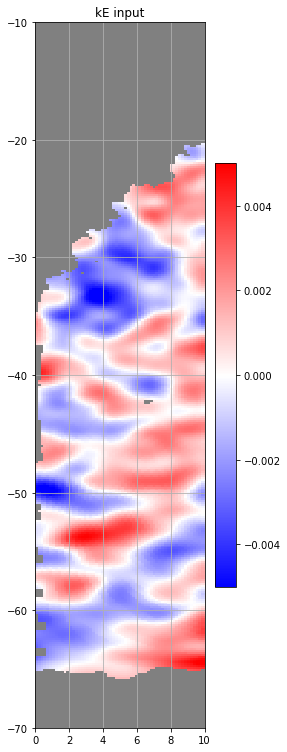

In [16]:
lonra = [0, 10]
latra = [-70, -10]
res_map = 10 
plot_map(kappa_mask_sm_msk, lonra, latra, res_map, title = 'kE input', vmin = -0.005, vmax = 0.005, x_len= 3,y_len=10 )

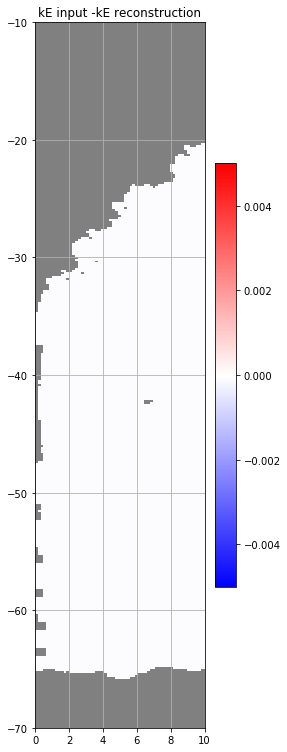

In [17]:
plot_map((kappa_mask_sm_msk- E_map_sm_msk), lonra, latra, res_map, vmin = -0.005, vmax = 0.005, title = 'kE input -kE reconstruction',x_len= 3,y_len=10 )

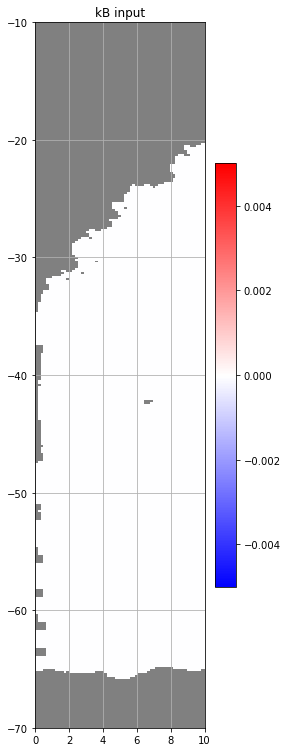

In [18]:
plot_map(B_map_sm_msk, lonra, latra, res_map, vmin = -0.005, vmax = 0.005, title = 'kB input' ,x_len= 3,y_len=10 )

# Effect of masking

In [19]:
gamma1_masked = np.copy(gamma1)
gamma2_masked= np.copy(gamma2)
K_masked = np.copy(K)
K_masked[mask] = 0.
gamma1_masked[mask] = 0.
gamma2_masked[mask] = 0.

kappa_mask1, kappa_map_alm1, E_map1, B_map1 = g2k_sphere(K_masked, gamma1_masked, gamma2_masked, np.ones(len(gamma1)), 1024, 2048, synfast=True, sm=False)

# smooth *****************************************************
kappa_mask_smoothed1= hp.sphtfunc.smoothing(kappa_mask1, sigma = sigma_smooth1)
E_map_smoothed1= hp.sphtfunc.smoothing(E_map1, sigma = sigma_smooth1)
B_map_smoothed1= hp.sphtfunc.smoothing(B_map1, sigma = sigma_smooth1)

# mask *********************
kappa_mask_sm_msk1 = np.ma.masked_where(mask, kappa_mask_smoothed1)
E_map_sm_msk1 = np.ma.masked_where(mask, E_map_smoothed1)
B_map_sm_msk1 = np.ma.masked_where(mask, B_map_smoothed1)

[  0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j
  -5.82994163e-06 +0.00000000e+00j ...,   1.46831902e-25 +3.61764266e-26j
   8.15554382e-26 -3.05351583e-26j   6.44818098e-27 +7.72272447e-26j]
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 30.000000 arcmin (0.008727 rad) 
-> fwhm is 70.644601 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 30.000000 arcmin (0.008727 rad) 
-> fwhm is 70.644601 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 30.000000 arcmin (0.008727 rad) 
-> fwhm is 70.644601 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


NameError: name 'kappa_map_alm_smoothed1' is not defined

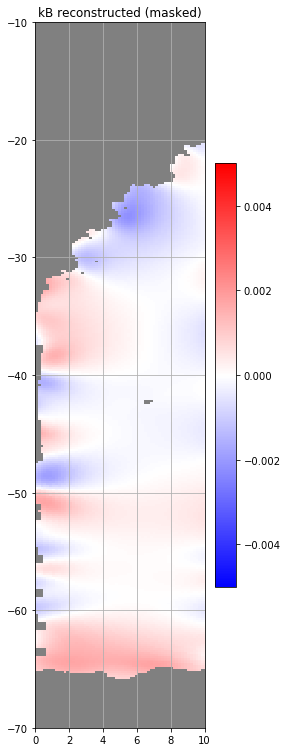

In [22]:
plot_map(B_map_sm_msk1, lonra, latra, res_map, vmin = -.005, vmax = 0.005, title = 'kB reconstructed (masked)', x_len= 3,y_len=10 )

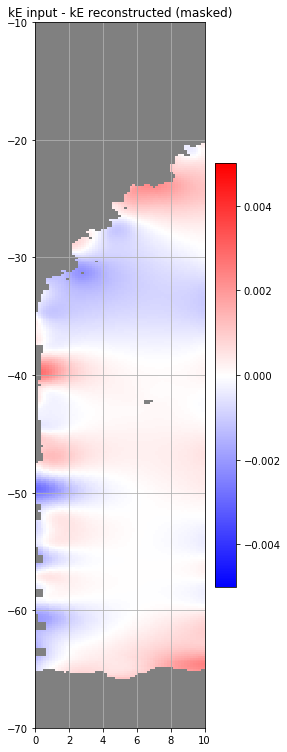

In [24]:
plot_map(kappa_mask_sm_msk-E_map_sm_msk1, lonra, latra, res_map, vmin = -.005, vmax = 0.005, title = 'kE input - kE reconstructed (masked)', x_len= 3,y_len=10 )

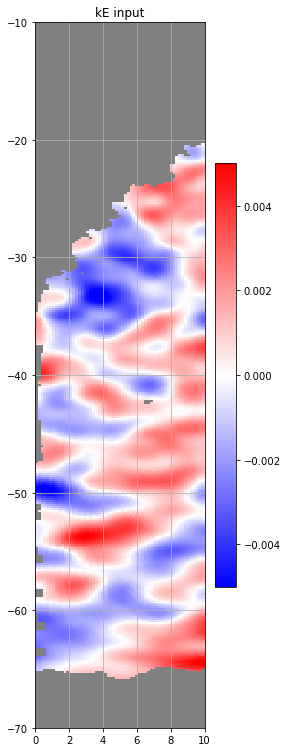

In [25]:
plot_map(E_map_sm_msk, lonra, latra, res_map, vmin = -.005, vmax = 0.005, title = 'kE input', x_len= 3,y_len=10 )

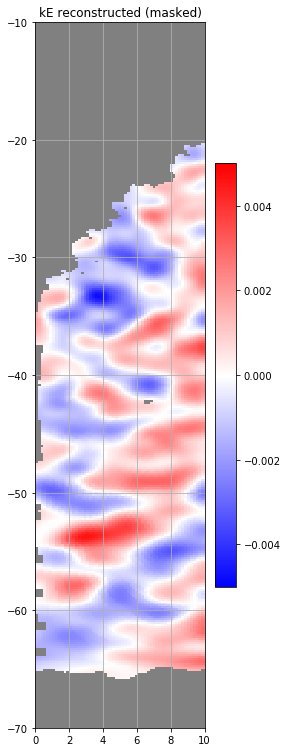

In [26]:
plot_map(E_map_sm_msk1, lonra, latra, res_map, vmin = -.005, vmax = 0.005, title = 'kE reconstructed (masked)',x_len= 3,y_len=10 )

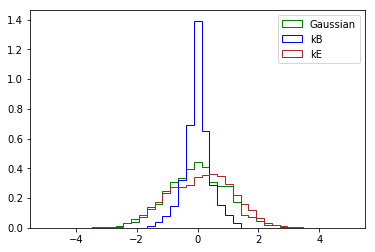

In [28]:
steps = 40
plt.hist(np.random.normal(0, 1., 3000), bins = np.linspace(-5,5,steps), normed = True,  color = 'green', histtype = 'step', label = 'Gaussian')
plt.hist(B_map_sm_msk1[~mask]/0.00136, bins = np.linspace(-5,5,steps), normed = True,  color = 'blue', histtype = 'step', label = 'kB')
#plt.hist((kappa_mask_sm_msk[~mask]-E_map_sm_msk1[~mask])/0.00136, bins = np.linspace(-5,5,steps), normed = True, color = 'red', histtype = 'step', label = 'kE-kE')
#plt.hist((kappa_mask_sm_msk[~mask])/0.00136, bins = np.linspace(-5,5,steps), normed = True, color = 'purple', histtype = 'step', label = 'kE masked')
plt.hist((E_map_sm_msk1[~mask])/0.00136, bins = np.linspace(-5,5,steps), normed = True, color = 'brown', histtype = 'step', label = 'kE')

plt.legend()


# F1 and F2 statistics

In [29]:
import kmeans_radec
from scipy import spatial
from kmeans_radec import KMeans, kmeans_sample

def IndexToDeclRa(index, nside):
    theta,phi=hp.pixelfunc.pix2ang(nside ,index)
    return -np.degrees(theta-np.pi/2.),np.degrees(phi)

def jaccknife_regions(ra,dec,number_of_regions):
    new_cat=np.array(zip(ra, dec))
    centers_jck= kmeans_radec.kmeans_sample(new_cat,number_of_regions,maxiter=100,tol=1e-05,verbose=0)
    centers_tree = spatial.cKDTree(centers_jck.centers[:,[0,1]])
    _ , hpix= centers_tree.query(np.array(zip(ra,dec)))
    return centers_tree, hpix, centers_jck.centers[:,[0,1]]

# define jackknife regions **********************
area = np.array(range(hp.nside2npix(nside)))[~mask]
dec,ra = IndexToDeclRa(area, nside)

centers_tree, hpix, centers = jaccknife_regions(ra,dec,30)

In [30]:
# compute statistics 

def zero_lag(map1,map2):
     return np.sum(map1*map2)/len(map1)
    
def zero_lag_F1_F2(kE,kEsm, hpix, mask):
    kE_masked = kE[mask]
    kEsm_masked = kEsm[mask]
    
    jck = len(np.unique(hpix))
    F1= np.zeros(jck)
    F2= np.zeros(jck)
    
    for j in range(jck):  
        mask_hpix = hpix != j
        k1k1 = zero_lag(kE_masked[mask_hpix],kE_masked[mask_hpix])
        k2k2 = zero_lag(kEsm_masked[mask_hpix],kEsm_masked[mask_hpix])
        k1k2 = zero_lag(kE_masked[mask_hpix],kEsm_masked[mask_hpix])
        F1[j] = np.sqrt(k1k1 / k2k2)
        F2[j] = k1k2 / k2k2
        
    fact=(jck -1.) / jck
    F1_ave = np.sum(F1) / jck
    F2_ave = np.sum(F2) / jck
    err_F1 = 0.
    err_F2 = 0.
    for j in range(jck): 
        err_F1 += fact * ( -F1_ave+F1[j]) * ( -F1_ave+F1[j])
        err_F2 += fact * ( -F2_ave+F2[j]) * ( -F2_ave+F2[j])

    F1_full = np.sqrt(zero_lag(kE_masked,kE_masked)/zero_lag(kEsm_masked,kEsm_masked))
    F2_full = zero_lag(kE_masked,kEsm_masked)/zero_lag(kEsm_masked,kEsm_masked)
    
    return F1_full, np.sqrt(err_F1), F2_full, np.sqrt(err_F2)


f1,f1e,f2,f2e = zero_lag_F1_F2(kappa_mask_sm_msk,E_map_sm_msk1, hpix, ~mask)

print 'F1 = {0:2.2f} +- {1:2.2f}'.format(f1,f1e)
print 'F2 = {0:2.2f} +- {1:2.2f}'.format(f2,f2e)

F1 = 1.29 +- 0.05
F2 = 1.21 +- 0.04


In [80]:
print zero_lag(B_map_sm_msk1[~mask], B_map_sm_msk1[~mask])
print zero_lag(E_map_sm_msk1[~mask], E_map_sm_msk1[~mask])
print zero_lag(E_map_sm_msk[~mask], E_map_sm_msk[~mask])

3.21642466966e-07
1.49093384002e-06
3.54714352413e-06


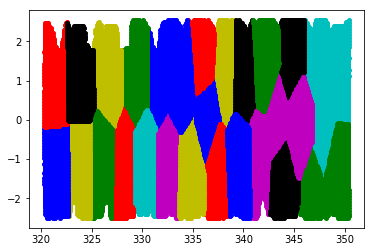

In [32]:
# plot jackknife regions in case ********************
color_i=[]
for gg in range(100):
    color_i.append('b')
    color_i.append('g')
    color_i.append('r')
    color_i.append('c')
    color_i.append('m')
    color_i.append('y')
    color_i.append('k')

fig= plt.figure()
ax = fig.add_subplot(111)
for j in range(len(np.unique(hpix))):
    mask2=hpix==j
    plt.plot(ra[mask2], dec[mask2], 'o', ms=4, alpha=1., color=color_i[j])
